In [5]:
# coding: utf-8
"""
コードテストをするためのコード
"""
from filer2.filer2 import Filer
# from library.submodular import SubModular, Vector, GraphSubModular
from library.graphsubmodular import Multiplex_GraphSubModular
import collections
import numpy as np
from scipy.spatial.distance import cosine, sqeuclidean
from scipy.sparse import csr_matrix, vstack, lil_matrix
import matplotlib.pylab as plt
from igraph import *
% pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
# 関数の定義
def cal_cost(list_c_word, distance_matrix, scale):
    """
    コスト１回分の計算
    """
    # 単語をidに変換
    list_c_id = sorted([dict_word_id[word] for word in list_c_word])
    dm = distance_matrix[:,list_c_id]
    f_C = 0.0
    for row in dm:
        if scale == 0:
            f_C -= np.exp(np.amin(row))
        elif scale == 1:
            f_C -= np.amin(row)
        else:
            f_C -= np.log(np.amin(row))
    return f_C

def greedy_1(list_C, list_id_document, distance_matrix, r=1, scale=0):
    """
    修正貪欲法のone loopのためのコード
    list_C: 要約文書の集合
    list_document: 追加する文書候補の集合
    distance_matrix: 各ノード間の距離, W * V
    r: コストに追加するハイパーパラメータ
    scale: scale関数、0: e^x, 1: x, 2: ln_x
    """
    # 現在のコストを計算
    
    # 一番初めの時
    if len(list_C) == 0:
        list_id_score = []
        for doc_id, document in list_id_document:
            list_c_word = sorted(list(set([word for word in document])))
            f_C = cal_cost(list_c_word, distance_matrix, scale)
            f_C /= (np.power(len(document), r))
            list_id_score.append([[doc_id, document], f_C])
        doc, _ = sorted(list_id_score, key=lambda x:x[1], reverse=True)[0]
        return doc
    else:
        # 単語のuniqueなリストを作成、単語をidに変換
        list_c_word = sorted(list(set([word for row in list_C for word in row[1]])))
        # f_C: 現在のコストの計算
        f_C = cal_cost(list_c_word, distance_matrix, scale)
        print f_C
        # 文書を１つずつ追加した時のコストの増分を計算
        list_id_score = []
        for doc_id, document in list_id_document:
            # 文章の追加
            list_c_word_s = list(set(list_c_word + document))
            # コストの計算
            f_C_s = cal_cost(list_c_word_s, distance_matrix, scale)
            # スコアの増分を計算
            delta = (f_C_s - f_C)/(np.power(len(document), r))
            list_id_score.append([[doc_id, document], delta])
        # スコアの増分が一番大きかったdocを返す
        doc, _ = sorted(list_id_score, key=lambda x:x[1], reverse=True)[0]
        return doc

def greedy(list_id_document, matrix, num_s = 5, r=1, scale=0):
    """
    修正貪欲法で文章の抽出を行うための関数
    list_id_document: 文idとbag of wordsが記録されたリスト
    matrix: ノード間の距離を記録したmatrix, V * V, numpy_array
    num_s: 抜き出したい文章数
    r: 文の長さに対するコスト
    scale: scale関数として何を使うか、0: e^x, 1: x, 2: ln_x
    """
    # 対角成分を0にする
    for i, row in enumerate(matrix):
        matrix[i][i] = 0.0
    # matrixをdistance_matrixに変換
    list_row = [matrix[dict_word_id[word]] for row in list_id_document for word in row[1]]
    distance_matrix = np.vstack(list_row)
    # 要約文章の集合
    list_C = []
    while len(list_C) < num_s:
        doc_id, doc = greedy_1(list_C=list_C,
                               list_id_document=list_id_document,
                               distance_matrix=distance_matrix,
                               r=r, scale=scale)
        list_C.append([doc_id, doc])
        list_id_document.remove([doc_id, doc])
    return list_C

### 動作確認

In [3]:
list_bag = []
elements = [i for i in range(60)]
weight_high = [2.5 for i in range(20)]
weight_middle = [2 for i in range(20)]
weight_low = [1.5 for i in range(20)]
weights = weight_high + weight_middle + weight_low
weights = np.array(weights)/float(np.sum(weights))

for i in range(40):
    list_tmp = []
    for j in range(4):
        list_tmp.append(np.random.choice(elements, p=weights))
    list_bag.append(list_tmp)
list_bag = [[str(num) for num in row] for row in list_bag]
list_id_document = [[i, row] for i, row in enumerate(list_bag)]
SM = SubModular(list_bag)
matrix = SM._cal_matrix_path_out(inverse_flag=True, weight=5)
dict_word_id = SM._dict_word_id
list_C = greedy(list_id_document, matrix, num_s = 5, r=1, scale=0)

-3304.70034887
-1039.91574261
-650.204457688
-485.062858572


library/submodular.py:155: RuntimeWarning: Couldn't reach some vertices at structural_properties.c:4482
  output='epath')


In [4]:
list_C

[[37, ['19', '2', '58', '30']],
 [3, ['51', '10', '37', '43']],
 [16, ['17', '31', '0', '7']],
 [8, ['6', '44', '40', '39']],
 [11, ['9', '40', '4', '45']]]

In [5]:
SM = SubModular(list_bag)
SM.m_greedy(num_s=5, r=1, scale=0)

-3304.70034887
-1039.91574261
-650.204457688
-485.062858572


In [8]:
SM.list_C

property: list_C


[[37, ['19', '2', '58', '30']],
 [3, ['51', '10', '37', '43']],
 [16, ['17', '31', '0', '7']],
 [8, ['6', '44', '40', '39']],
 [11, ['9', '40', '4', '45']]]

In [9]:
list_edgelist = []
for row in list_bag:
    for i in range(len(row)-1):
        list_edgelist.append((row[i], row[i+1]))

list_edge = []
for edge, weight in collections.Counter(list_edgelist).items():
    list_edge.append([edge, weight])

In [10]:
list_node = sorted(list(set([node for row in list_edge for node in row[0]])))

In [12]:
import networkx as nx
Graph = nx.DiGraph()
Graph.add_nodes_from(list_node)
for row in list_edge:
    Graph.add_edge(row[0][0], row[0][1], weight=row[1])

In [13]:
pos = nx.spring_layout(Graph)

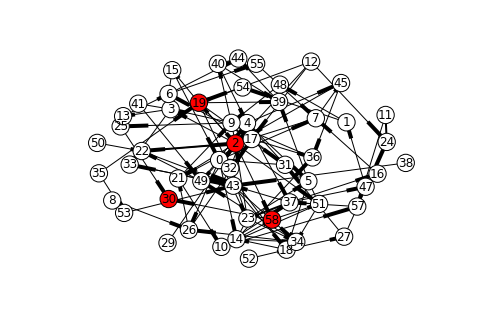

In [19]:
plt.figure()
#nx.draw_networkx_nodes(Graph, pos, node_size=200, node_color='white')
listcolor = []
for num in Graph.nodes():
    if num in list_C[0][1]:
        listcolor.append('#ff0000')
    else:
        listcolor.append('w')
weights = [Graph[u][v]['weight'] for u,v in Graph.edges()]
nx.draw(Graph, pos, with_labels=True, node_color=listcolor, width=weights*10)
plt.show()

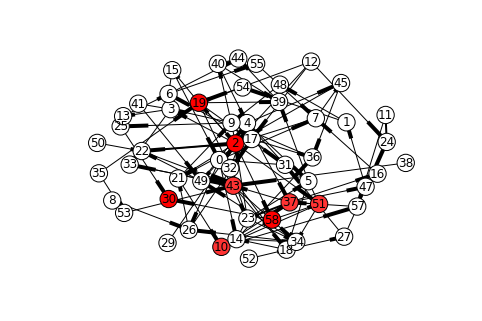

In [24]:
plt.figure()
#nx.draw_networkx_nodes(Graph, pos, node_size=200, node_color='white')
listcolor = []
for num in Graph.nodes():
    if num in list_C[1][1]:
        listcolor.append('#ff3333')
    elif num in list_C[0][1]:
        listcolor.append('#ff0000')
    else:
        listcolor.append('w')
weights = [Graph[u][v]['weight'] for u,v in Graph.edges()]
nx.draw(Graph, pos, with_labels=True, node_color=listcolor, width=weights*10)
plt.show()

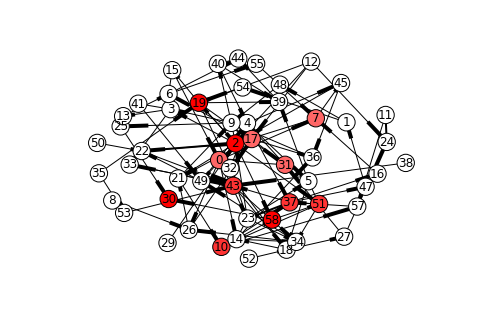

In [25]:
plt.figure()
#nx.draw_networkx_nodes(Graph, pos, node_size=200, node_color='white')
listcolor = []
for num in Graph.nodes():
    if num in list_C[2][1]:
        listcolor.append('#ff6666')
    elif num in list_C[1][1]:
        listcolor.append('#ff3333')
    elif num in list_C[0][1]:
        listcolor.append('#ff0000')
    else:
        listcolor.append('w')
weights = [Graph[u][v]['weight'] for u,v in Graph.edges()]
nx.draw(Graph, pos, with_labels=True, node_color=listcolor, width=weights*10)
plt.show()

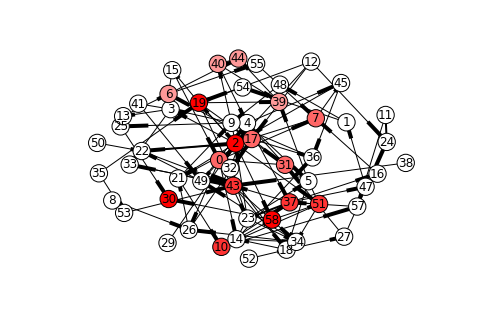

In [26]:
plt.figure()
#nx.draw_networkx_nodes(Graph, pos, node_size=200, node_color='white')
listcolor = []
for num in Graph.nodes():
    if num in list_C[3][1]:
        listcolor.append('#ff9999')
    elif num in list_C[2][1]:
        listcolor.append('#ff6666')
    elif num in list_C[1][1]:
        listcolor.append('#ff3333')
    elif num in list_C[0][1]:
        listcolor.append('#ff0000')
    else:
        listcolor.append('w')
weights = [Graph[u][v]['weight'] for u,v in Graph.edges()]
nx.draw(Graph, pos, with_labels=True, node_color=listcolor, width=weights*10)
plt.show()

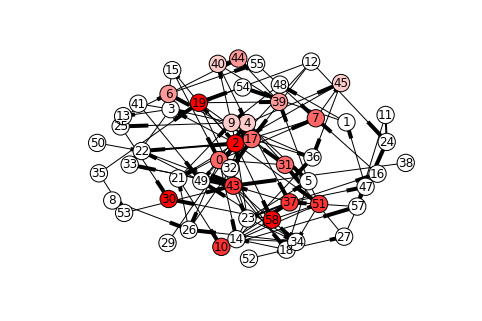

In [27]:
plt.figure()
#nx.draw_networkx_nodes(Graph, pos, node_size=200, node_color='white')
listcolor = []
for num in Graph.nodes():
    if num in list_C[4][1]:
        listcolor.append('#ffcccc')
    elif num in list_C[3][1]:
        listcolor.append('#ff9999')
    elif num in list_C[2][1]:
        listcolor.append('#ff6666')
    elif num in list_C[1][1]:
        listcolor.append('#ff3333')
    elif num in list_C[0][1]:
        listcolor.append('#ff0000')
    else:
        listcolor.append('w')
weights = [Graph[u][v]['weight'] for u,v in Graph.edges()]
nx.draw(Graph, pos, with_labels=True, node_color=listcolor, width=weights*10)
plt.show()

In [3]:
### ネットワーク構造を用いた文書間の距離の測り方

In [4]:
dict_test = Filer.readdump('./files/OpinosisDataset1.0/preprocessed/test/accuracy_garmin_nuvi_255W_gps.dump')

In [30]:
list_sentence = []
list_sep = []
list_sep_all = []
list_edgelist = []
for sen, sep, sepall, edge in zip(dict_test['sentence'],
                                  dict_test['sep_all'],
                                  dict_test['sep_all'],
                                  dict_test['edge_all']):
    if len(sepall) <= 100 and len(sep) != 0:
        list_sentence.append(sen)
        list_sep.append(sep)
        list_sep_all.append(sepall)
        list_edgelist.append(edge)

list_edgelist = [[row1[0], row1[1]] for row in list_edgelist for row1 in row]

In [34]:
directed = False

GM = GraphSubModular(list_sep_all=list_sep_all,
                     list_sep=list_sep,
                     list_edgelist=list_edgelist,
                     directed=directed,
                     inverse_flag=True)

In [35]:
matrix = GM.matrix
num1 = 1
dict_word_id = GM.dict_word_id
list_word1 = [dict_word_id[word] for word in list_sep[num1]]
list_sim = []
for i, row in enumerate(list_sep):
    list_word2 = [dict_word_id[word] for word in row]
    matrix_rev = matrix[list_word1][:,list_word2]
    list_sim.append([i, np.average(np.amin(matrix_rev, axis=1))])

list_sim = sorted(list_sim, key=lambda x:x[1])

print list_sentence[num1]
for i in range(10):
    print list_sim[i][1], list_sentence[list_sim[i][0]]

property: matrix
property: dict_word_id
but for the most part we find that the Garmin software provides accurate directions whereever we intend to go
0.0 but for the most part we find that the Garmin software provides accurate directions whereever we intend to go
0.763157894737 Depending on what you are using it for it is a nice adjunct to a travel trip and the directions are accurate and usually the quickest but not always
0.815789473684 The most accurate review stated that these machines are adjunct to a good map and signs on the interstate
0.842105263158 I found the maps to be inaccurate at first but after I updated them from Garmin 's website everything is golden
0.842105263158 I used it the day I bought it and then this morning and as soon as it comes on it is ready to navigate The only downfall of this product and the only reason I did not give it 5 stars is the fact that the speed limit it displays for the road you are on is n't 100 % accurate
0.842105263158 The only glitch I ha

### 動作確認

In [90]:
list_bag = []
elements = [i for i in range(100)]
weight_high = [2.5 for i in range(20)]
weight_middle = [2 for i in range(20)]
weight_low = [1.5 for i in range(10)]
weight_none = [0 for i in range(40)]
weights1 = weight_high + weight_middle + weight_low + weight_none
weights1 = np.array(weights1)/float(np.sum(weights1))

for i in range(40):
    list_tmp = []
    for j in range(4):
        list_tmp.append(np.random.choice(elements, p=weights1))
    list_bag.append(list_tmp)
    
weights2 = weight_none + weight_low + weight_middle + weight_high
weights2 = np.array(weights2)/float(np.sum(weights2))

for i in range(40):
    list_tmp = []
    for j in range(4):
        list_tmp.append(np.random.choice(elements, p=weights2))
    list_bag.append(list_tmp)

list_bag = [[str(num) for num in row] for row in list_bag]
list_id_document = [[i, row] for i, row in enumerate(list_bag)]
MGSM = Multiplex_GraphSubModular(list_sep_all=list_bag,
                                 list_sep=list_bag,
                                 weighted=True)
MGSM.m_greedy(num_w=20,
              r=1,
              scale=0,
              a=0.7,
              b=0.3)

計算が終了しました


In [91]:
list_edgelist = []
for row in list_bag:
    for i in range(len(row)-1):
        list_edgelist.append((row[i], row[i+1]))

list_edge = []
for edge, weight in collections.Counter(list_edgelist).items():
    list_edge.append([edge, weight])
list_node = sorted(list(set([node for row in list_edge for node in row[0]])))

import networkx as nx
Graph = nx.Graph()
Graph.add_nodes_from(list_node)
for row in list_edge:
    Graph.add_edge(row[0][0], row[0][1], weight=row[1])
    
pos = nx.spring_layout(Graph)

property: list_C


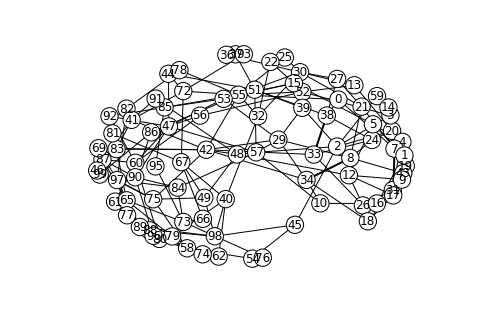

In [92]:
list_C = MGSM.list_C
plt.figure()
#nx.draw_networkx_nodes(Graph, pos, node_size=200, node_color='white')
listcolor = []
for num in Graph.nodes():
    if num in list_C[0][1]:
        listcolor.append('w')
    #elif num in list_C[3][1]:
        #listcolor.append('#ff3333')
    #elif num in list_C[2][1]:
        #listcolor.append('#ff6666')
    #elif num in list_C[1][1]:
        #listcolor.append('#ff9999')
    #elif num in list_C[0][1]:
        #listcolor.append('#ffcccc')
    else:
        listcolor.append('w')
weights = [Graph[u][v]['weight'] for u,v in Graph.edges()]
nx.draw(Graph, pos, with_labels=True, node_color=listcolor, width=weights*10)
plt.show()

property: list_C


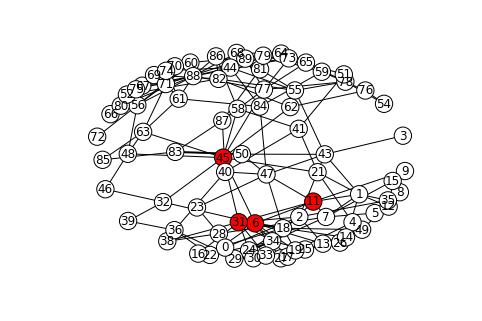

In [89]:
list_C = MGSM.list_C
plt.figure()
#nx.draw_networkx_nodes(Graph, pos, node_size=200, node_color='white')
listcolor = []
for num in Graph.nodes():
    if num in list_C[0][1]:
        listcolor.append('#ff0000')
    #elif num in list_C[3][1]:
        #listcolor.append('#ff3333')
    #elif num in list_C[2][1]:
        #listcolor.append('#ff6666')
    #elif num in list_C[1][1]:
        #listcolor.append('#ff9999')
    #elif num in list_C[0][1]:
        #listcolor.append('#ffcccc')
    else:
        listcolor.append('w')
weights = [Graph[u][v]['weight'] for u,v in Graph.edges()]
nx.draw(Graph, pos, with_labels=True, node_color=listcolor, width=weights*10)
plt.show()

property: list_C


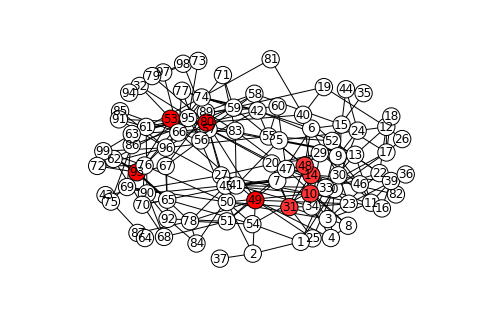

In [79]:
list_C = MGSM.list_C
plt.figure()
#nx.draw_networkx_nodes(Graph, pos, node_size=200, node_color='white')
listcolor = []
for num in Graph.nodes():
    if num in list_C[0][1]:
        listcolor.append('#ff0000')
    elif num in list_C[1][1]:
        listcolor.append('#ff3333')
    #elif num in list_C[2][1]:
        #listcolor.append('#ff6666')
    #elif num in list_C[1][1]:
        #listcolor.append('#ff9999')
    #elif num in list_C[0][1]:
        #listcolor.append('#ffcccc')
    else:
        listcolor.append('w')
weights = [Graph[u][v]['weight'] for u,v in Graph.edges()]
nx.draw(Graph, pos, with_labels=True, node_color=listcolor, width=weights*10)
plt.show()

property: list_C


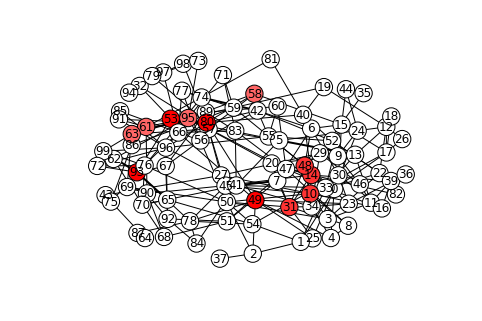

In [80]:
list_C = MGSM.list_C
plt.figure()
#nx.draw_networkx_nodes(Graph, pos, node_size=200, node_color='white')
listcolor = []
for num in Graph.nodes():
    if num in list_C[0][1]:
        listcolor.append('#ff0000')
    elif num in list_C[1][1]:
        listcolor.append('#ff3333')
    elif num in list_C[2][1]:
        listcolor.append('#ff6666')
    #elif num in list_C[1][1]:
        #listcolor.append('#ff9999')
    #elif num in list_C[0][1]:
        #listcolor.append('#ffcccc')
    else:
        listcolor.append('w')
weights = [Graph[u][v]['weight'] for u,v in Graph.edges()]
nx.draw(Graph, pos, with_labels=True, node_color=listcolor, width=weights*10)
plt.show()

property: list_C


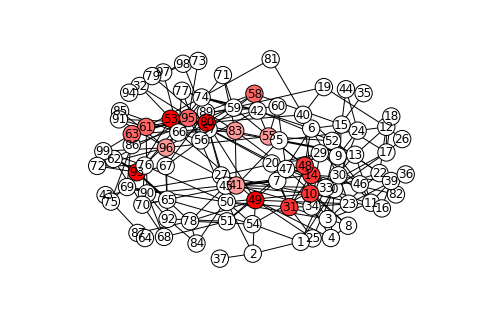

In [81]:
list_C = MGSM.list_C
plt.figure()
#nx.draw_networkx_nodes(Graph, pos, node_size=200, node_color='white')
listcolor = []
for num in Graph.nodes():
    if num in list_C[0][1]:
        listcolor.append('#ff0000')
    elif num in list_C[1][1]:
        listcolor.append('#ff3333')
    elif num in list_C[2][1]:
        listcolor.append('#ff6666')
    elif num in list_C[3][1]:
        listcolor.append('#ff9999')
    #elif num in list_C[0][1]:
        #listcolor.append('#ffcccc')
    else:
        listcolor.append('w')
weights = [Graph[u][v]['weight'] for u,v in Graph.edges()]
nx.draw(Graph, pos, with_labels=True, node_color=listcolor, width=weights*10)
plt.show()

property: list_C


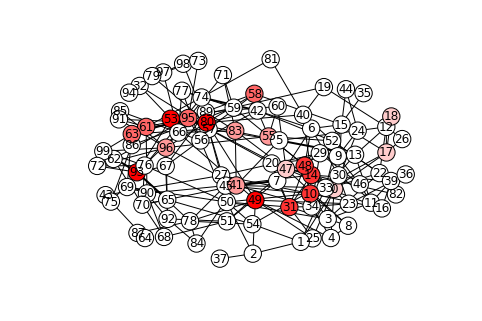

In [82]:
list_C = MGSM.list_C
plt.figure()
#nx.draw_networkx_nodes(Graph, pos, node_size=200, node_color='white')
listcolor = []
for num in Graph.nodes():
    if num in list_C[0][1]:
        listcolor.append('#ff0000')
    elif num in list_C[1][1]:
        listcolor.append('#ff3333')
    elif num in list_C[2][1]:
        listcolor.append('#ff6666')
    elif num in list_C[3][1]:
        listcolor.append('#ff9999')
    elif num in list_C[4][1]:
        listcolor.append('#ffcccc')
    else:
        listcolor.append('w')
weights = [Graph[u][v]['weight'] for u,v in Graph.edges()]
nx.draw(Graph, pos, with_labels=True, node_color=listcolor, width=weights*10)
plt.show()